ADF Test — Original
  Statistic: -2.9974704379012915
  p-value:   0.03513130577311748

ADF Test — First Difference (d=1)
  Statistic: -1.6967779051285394
  p-value:   0.4327733570820209

ADF Test — Seasonal Difference (D=1)
  Statistic: -1.9960715233213346
  p-value:   0.28829825140887594

ADF Test — d=1 and D=1
  Statistic: -0.7398716324593456
  p-value:   0.8361498729698638

(0, 0, 0) x (0, 0, 0, 12) -> RMSE 1720.28
(0, 0, 0) x (0, 0, 1, 12) -> RMSE 939.35
(0, 0, 0) x (0, 1, 0, 12) -> RMSE 3327.28
(0, 0, 0) x (0, 1, 1, 12) -> RMSE 2949.18
(0, 0, 0) x (1, 0, 0, 12) -> RMSE 1100.41
(0, 0, 0) x (1, 0, 1, 12) -> RMSE 763.53
(0, 0, 0) x (1, 1, 0, 12) -> RMSE 3645.43
(0, 0, 0) x (1, 1, 1, 12) -> RMSE 3669.02
(0, 0, 1) x (0, 0, 0, 12) -> RMSE 1316.09
(0, 0, 1) x (0, 0, 1, 12) -> RMSE 3222.05
(0, 0, 1) x (0, 1, 0, 12) -> RMSE 2906.52
(0, 0, 1) x (0, 1, 1, 12) -> RMSE 2967.81
(0, 0, 1) x (1, 0, 0, 12) -> RMSE 1172.64
(0, 0, 1) x (1, 0, 1, 12) -> RMSE 1172.69
(0, 0, 1) x (1, 1, 0, 12) -> RMSE 

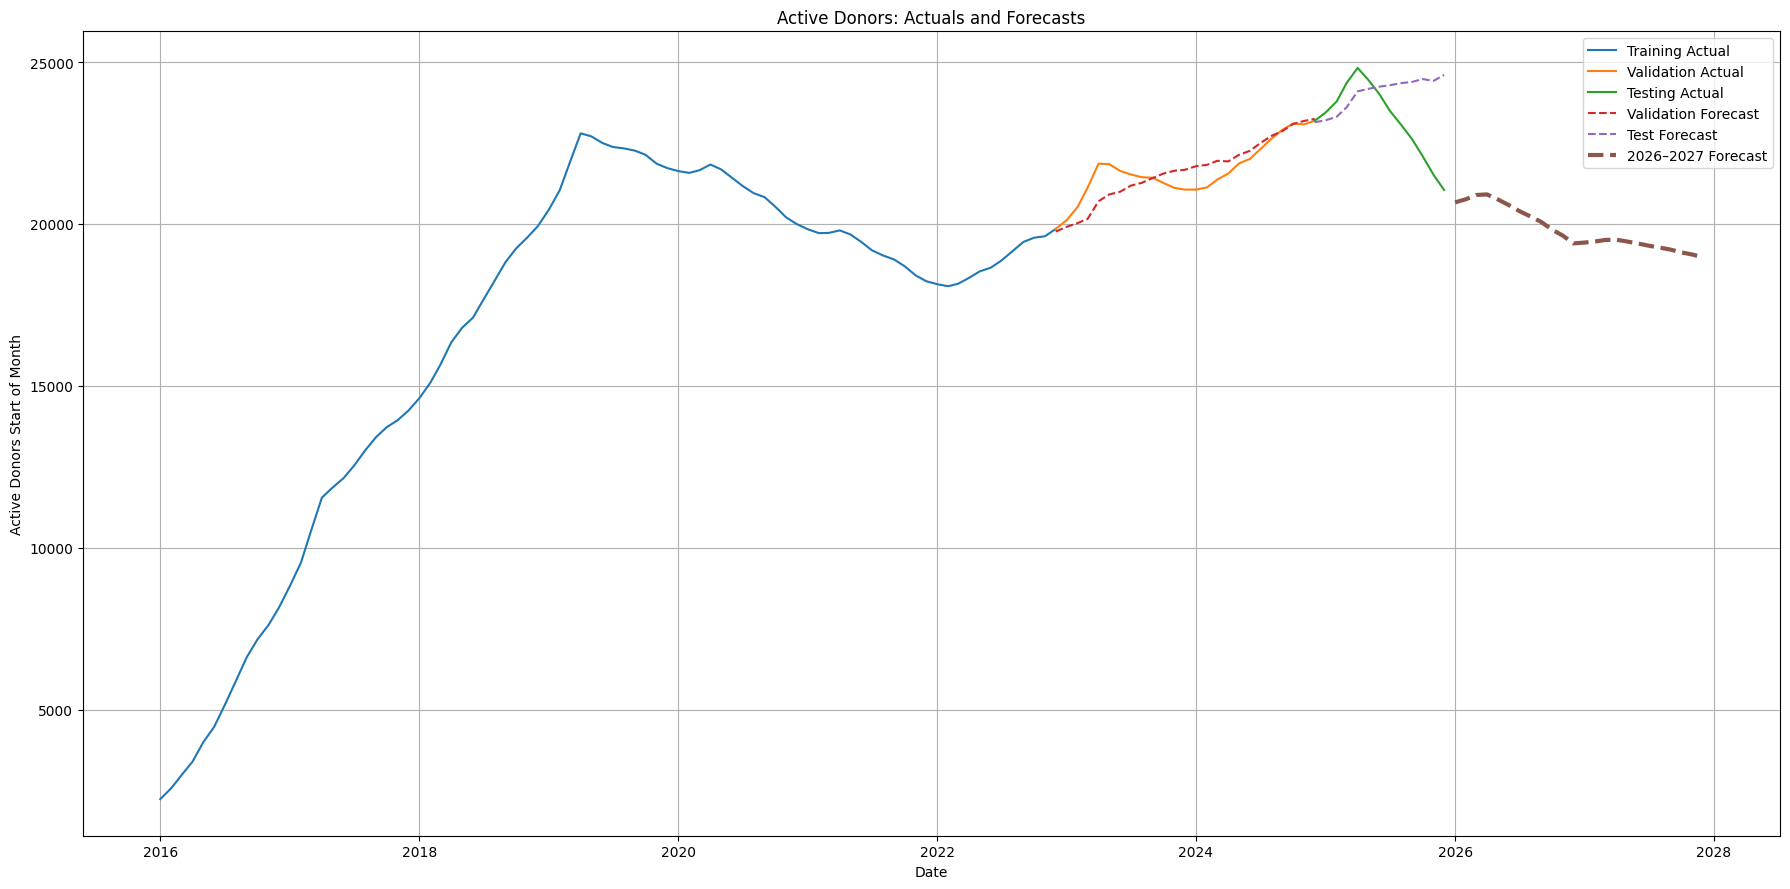

Forecast exported to: /Users/noahmancione/OneDrive/Noah Python Projects/Capstone Project/Forecast_Output_2026_2027.xlsx


In [ ]:

# pip install pandas numpy matplotlib scikit-learn statsmodels openpyxl

import pandas as pd
import numpy as np
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


# LOAD DATA

df = pd.read_excel('/Users/noahmancione/OneDrive/Noah Python Projects/Capstone Project/Sample Non-profit Data 2015-2025.xlsx')

df["date"] = pd.to_datetime(
    df["Fiscal Year-Month Label"].str.replace(" - ", "-") + "-01"
)

df = df.set_index("date").sort_index()

# Target variable
y = df["Active Donors Start of Month"]

# Exogenous variables
exog = df[["New Donors", "Cancellations", "Average Amount (Active)"]]



# TRAIN / VALIDATION / TEST SPLIT


train_end = "2022-12-01"
val_end =   "2024-12-01"

y_train = y[:train_end]
y_val   = y[train_end:val_end]
y_test  = y[val_end:]

exog_train = exog.loc[y_train.index]
exog_val   = exog.loc[y_val.index]
exog_test  = exog.loc[y_test.index]



# ADF Tests (optional, but kept for completeness)


from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=""):
    result = adfuller(series.dropna())
    print(f"ADF Test — {title}")
    print(f"  Statistic: {result[0]}")
    print(f"  p-value:   {result[1]}\n")

adf_test(y_train, "Original")
adf_test(y_train.diff(), "First Difference (d=1)")
adf_test(y_train.diff(12), "Seasonal Difference (D=1)")
adf_test(y_train.diff().diff(12), "d=1 and D=1")



# GRID SEARCH — FIND BEST SARIMAX PARAMETERS

p_vals = [0, 1, 2]
d_vals = [0, 1]
q_vals = [0, 1, 2]
P_vals = [0, 1]
D_vals = [0, 1]
Q_vals = [0, 1]
m = 12  # monthly seasonality

def sarimax_grid_search(y_train, y_val, ex_train, ex_val):
    best_rmse = np.inf
    best_cfg = None

    for p, d, q, P, D, Q in itertools.product(p_vals, d_vals, q_vals, P_vals, D_vals, Q_vals):

        order = (p, d, q)
        seasonal = (P, D, Q, m)

        try:
            model = SARIMAX(
                y_train, exog=ex_train,
                order=order, seasonal_order=seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fit = model.fit(disp=False)

            pred = fit.get_forecast(steps=len(y_val), exog=ex_val).predicted_mean
            rmse = np.sqrt(mean_squared_error(y_val, pred))

            print(f"{order} x {seasonal} -> RMSE {rmse:.2f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_cfg = (order, seasonal)

        except:
            continue

    print("\nBest model found:", best_cfg, "RMSE:", best_rmse)
    return best_cfg

order, seasonal = sarimax_grid_search(
    y_train, y_val,
    exog_train, exog_val
)


# TRAIN → VALIDATION FORECAST

model_train = SARIMAX(
    y_train, exog=exog_train,
    order=order, seasonal_order=seasonal,
    enforce_stationarity=False, enforce_invertibility=False
)

fit_train = model_train.fit(disp=False)
val_pred = fit_train.get_forecast(steps=len(y_val), exog=exog_val).predicted_mean


# TRAIN+VAL → TEST FORECAST

y_trainval = pd.concat([y_train, y_val])
exog_trainval = pd.concat([exog_train, exog_val])

model_trainval = SARIMAX(
    y_trainval, exog=exog_trainval,
    order=order, seasonal_order=seasonal,
    enforce_stationarity=False, enforce_invertibility=False
)

fit_trainval = model_trainval.fit(disp=False)
test_pred = fit_trainval.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean


# FULL MODEL → 24-MONTH FUTURE FORECAST

y_full = y
exog_full = exog

# Build future dates
future_index = pd.date_range(
    start=y_full.index.max() + pd.offsets.MonthBegin(1),
    periods=24,
    freq="MS"
)

# Future exogenous assumptions
exog_future_mean = exog_full.iloc[-12:].mean()

exog_future = pd.DataFrame(
    [exog_future_mean.values] * 24,
    index=future_index,
    columns=exog_full.columns
)

model_full = SARIMAX(
    y_full,
    exog=exog_full,
    order=order, seasonal_order=seasonal,
    enforce_stationarity=False, enforce_invertibility=False
)

fit_full = model_full.fit(disp=False)
future_pred = fit_full.get_forecast(steps=24, exog=exog_future).predicted_mean


# PLOT RESULTS

plt.figure(figsize=(18, 9))

plt.plot(y_train.index, y_train, label="Training Actual")
plt.plot(y_val.index,   y_val,   label="Validation Actual")
plt.plot(y_test.index,  y_test,  label="Testing Actual")

plt.plot(y_val.index,  val_pred, "--", label="Validation Forecast")
plt.plot(y_test.index, test_pred, "--", label="Test Forecast")
plt.plot(future_pred.index, future_pred, "--", linewidth=3, label="2026–2027 Forecast")

plt.title("Active Donors: Actuals and Forecasts")
plt.xlabel("Date")
plt.ylabel("Active Donors Start of Month")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ======================================================
# EXPORT FUTURE FORECAST TO EXCEL
# ======================================================

forecast_output = pd.DataFrame({
    "Date": future_pred.index,
    "Forecast_Active_Donors_Start_of_Month": future_pred.values
})

forecast_output["Date"] = pd.to_datetime(forecast_output["Date"])

export_path = "/Users/noahmancione/OneDrive/Noah Python Projects/Capstone Project/Forecast_Output_2026_2027.xlsx"
forecast_output.to_excel(export_path, index=False)

print("Forecast exported to:", export_path)
